# 랜덤 포레스트
- 배깅의 대표적인 알고리즘
- 앙상블 알고리즘 중 비교적 빠른 수행속도
- 높은 예측 성능 보유
- 결정 트리가 기반 알고리즘으로 결정트리의 장점인 쉽고 직관적인 장점을 가지고 있음

 ![image](https://user-images.githubusercontent.com/70187490/128863873-7a3c814a-605b-40c3-a5f5-1d6802e7e4fa.png)

랜덤 포레스트는  
1. 여러 개의 결정 트리 분류기가  
2. 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 
3. 개별적으로 학습을 수행한 뒤 
4. 최종적으로 모든 분류기가 보팅을 통해 예측 결정을 하게 됌

![image](https://user-images.githubusercontent.com/70187490/128864801-d14b970e-63f9-4aa3-b17d-bb7584a1f2f3.png)

<br>

- 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트
- 여러 개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑(bootstrapping) 분할 방식  
- 랜덤 포레스트의 서브세트(Subset) 데이터는 이러한 부트스트래핑으로 데이터가 만들어짐  
- 서브 세트의 데이터 건수는 전체 데이터 건수와 동일하지만, 개별 데이터가 중첩되어 만들어짐

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0] + '_'+str(x[1])
                                                                                              if x[1] > 0 else x[0], axis=1)
    new_feature_name_df=new_feature_name_df.drop(['index'], axis=1)
    
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('D:\Python/human_activity/features.txt', sep='\s+',
                                  header=None, names=['column_index', 'column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('D:\Python/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('D:\Python/human_activity/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('D:\Python/human_activity/train/y_train.txt', sep='\s+', names=['action'])
    y_test = pd.read_csv('D:\Python/human_activity/test/y_test.txt', sep='\s+', names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = get_human_dataset()

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝
트리 기반의 앙상블 알고리즘의 단점:
- 하이퍼 파라미터가 많음
- 그로 인한 튜닝 시간이 많이 소모 됌
- 튜닝을 했음에도 불구하고 예측 성능이 크게 향상되지 않음  

>트리 기반 자체의 하이퍼 파라미터가 원래 많은 데다 베깅, 부스팅, 학습, 정규화 등의 하이퍼 파라미터까지 추가되므로 일반적인 ML 알고리즘에 비해 많음  
그나마 랜덤 포레스트가 적은 편에 속함 -> 결정 트리에서 사용되는 하이퍼 파라미터와 같은 파라미터가 대부분이기 때문
<br> 

n_estimators: 
- 랜덤 포레스트에서 결정 트리의 개수를 지정 <Default=10>
- 많이 설정할 수록 좋은 것은 아니며, 늘릴수록 학습 수행시간이 오래 걸림  

<br>

max_features:
- 결정트리에서 사용하는 max_features와 동일
- Default값이 'None'이 아닌 'auto', 즉 'sqrt'와 같음  

<br>

max_depth나 min_samples_leaf와 같이 결정트리에서 과적합을 개선하기 위해 사용되는 파라미터가 랜덤 포레스트에도 똑같이 적용 가능  

> 랜덤 포레스트는 CPU 병렬 처리도 효과적으로 수행되어 빠른 학습이 가능하기 때문에 그레디언트 부스팅보다 예측 성능이 약간 떨어지더라도 랜덤포레스트로 기반 모델을 먼저 구축하는 경우가 많음

In [7]:
from sklearn.model_selection import GridSearchCV

params ={
    'n_estimators':[100],
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf,
                       param_grid=params,
                       cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [9]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8,
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)

print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


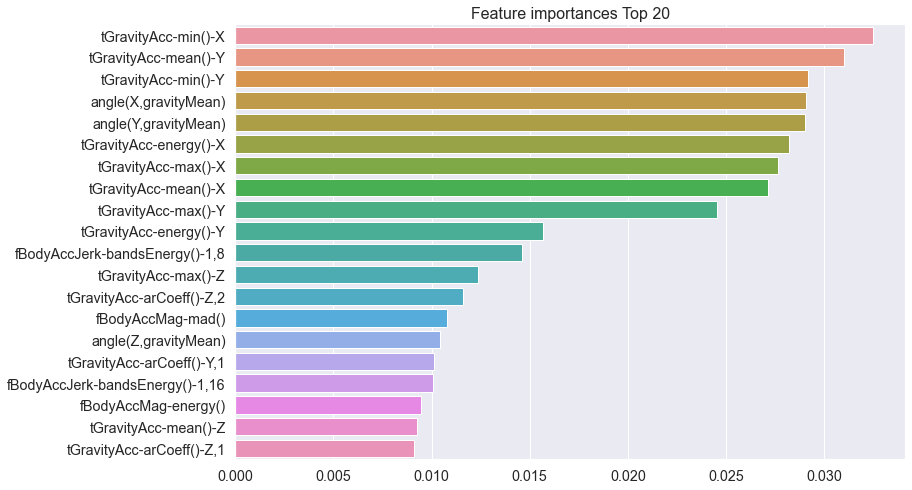

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(12, 8))
plt.title('Feature importances Top 20', fontsize=16)
sns.barplot(x=ftr_top20, y=ftr_top20.index)
sns.set(font_scale = 1.5)
plt.show()